In [ ]:
%run bga.puertorico.common.ipynb

import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly

## Utils

In [ ]:
def copy_ids(src, dst):
    dst['table_id']  = src['table']
    dst['file_name'] = src['file_name']
    return dst    

def get_logs(data):
    result = select_one('$[*].log.data.data')(data)
    copy_ids(data, result)
    return result

def get_stats(data):
    result = select_one('$..data[?(@.type == "gameStateChange" & @.args.action == "stGameEnd")].args.args')(data)
    copy_ids(data, result)
    return result

In [ ]:
def steps(log):
    return (sub_move for move in log for sub_move in move['data'])

In [ ]:
def stepsWithCounters(log):
    gvnr, roln, role = 0, 0, ''
    for move_id, move in enumerate(log):
        for sub_move_id, sub_move in enumerate(move['data']):
            if sub_move['type'] in ['gameStateChange', 'updateReflexionTime', 'gameStateMultipleActiveUpdate', 'wakeupPlayers']:
                continue
            elif sub_move['type'] == 'newGovernor':
                gvnr += 1
                roln = -1
                role = ''
            elif sub_move['type'] == 'roleSelected':
                roln += 1
                role = sub_move['args']['rol_type']
            yield sub_move, (gvnr, roln, role, move_id, sub_move_id)

In [ ]:
def stepsOfType(log, typ):
    return (s['args'] for s in steps(log) if s['type'] == typ)

In [ ]:
def stepsOfPlayer(log, player):
    return ((s,n) for s,n in stepsWithCounters(log) if s['args'] and s['args'].get('player_name', '') == player)

In [ ]:
def stats(sz = 1000): 
    return collect_data(with_progress(games[:sz], sz), get_stats)

def logs(sz = 1000):
    return collect_data(with_progress(games[:sz], sz), get_logs)

In [ ]:
def log_of(step):
    return step['log'].format(**step['args'] if isinstance(step['args'], dict) else {}).replace('$', '')

## Prepare data

In [ ]:
table_stats = {
     '1': '_',
     '4': 'Game duration',
     '3': 'Players average level',
     '2': 'Average score',
    '10': 'Unclaimed victory points',
    '11': 'Unclaimed colonists',
    '12': 'Doubloons in the bank',
    '13': 'Unclaimed plantations',
    '14': 'Unclaimed quarries',
    '15': 'Unclaimed small buildings',
    '16': 'Unclaimed large buildings'}

player_stats = {
     '1': 'Thinking time',
    '10': 'VPs earned by shipping',
    '11': 'VPs earned by building',
    '12': 'VPs earned from large buildings',
    '13': 'Doubloons owned at game end',
    '14': 'Good barrels owned at game end',
    '15': 'Colonists',
    '16': 'Plantations',
    '17': 'Quarries',
    '18': 'Small buildings',
    '19': 'Large buildings'}

In [ ]:
from os import listdir
from os.path import isfile, join

game = 'pr'
games = [join(game, f) for f in listdir(game) if f.endswith('.json')]
games.sort(reverse=True)
len(games)

In [ ]:
stats_cache = cached_to_disk(lambda: list(stats()), 'stats.json')

In [ ]:
f = games[1]
data1 = load_from_json_file(f)
game_log = data1['log']['data']['data']['data']
stat = game_log[-1]['data'][-2]['args']['args']
# JSON(stat, root='stat')

In [ ]:
plt.rcParams['figure.figsize'] = [16, 10]

In [ ]:
%load_ext memory_profiler
%load_ext autotime

# ACTIVE DEVELOPMENT ZONE

In [ ]:
name_step = lambda s: dict(zip(('gvnr#', 'role#', 'role', 'move#', 'sub_move#'), s))
def join(d1,d2):
    d1.update(d2)
    return d1
                               
data = [{'1_type':s['type'], 'args':s['args']} for s,n in stepsOfPlayer(game_log, 'hysbe41')]
json_normalize(data).fillna('').head(10)

In [39]:
data = [(*n, s['type'], log_of(s)) for s,n in stepsOfPlayer(game_log, 'hysbe41')]
pd.DataFrame(data, columns=['gvnr#', 'role#', 'role', 'move#', 'sub_move#', 'type', 'log']).head(10)

,gvnr#,role#,role,move#,sub_move#,type,log
0,0,1,settler,5,0,plantationSettlement,hysbe41 got a new plantation (sugar)
1,0,2,builder,9,0,buildingBought,hysbe41 bought a new building for 2 doubloons ...
2,0,3,mayor,12,4,colonistsEarnedFromShip,hysbe41 gets 1 colonist from the ship
3,0,3,mayor,14,0,colonistToPlantation,hysbe41 sets a colonist to work in his plantation
4,0,3,mayor,19,0,message,hysbe41 finished dispatching his colonists
5,0,4,prospector,24,0,roleSelected,hysbe41 selected the prospector
6,0,4,prospector,24,2,doubloonsEarned,hysbe41 earned 1 doubloon as his privilege
7,1,0,mayor,26,5,colonistsEarnedFromShip,hysbe41 gets 1 colonist from the ship
8,1,0,mayor,32,0,colonistToSanJuan,hysbe41 sends a colonist back to San Juan
9,1,0,mayor,35,0,colonistToPlantation,hysbe41 sets a colonist to work in his plantation


time: 44.8 ms


In [35]:
{s['type'] for s in steps(game_log)}

{'buildingBought',
 'colonistToBuilding',
 'colonistToPlantation',
 'colonistToSanJuan',
 'colonistsEarnedFromShip',
 'colonistsEarnedFromSupply',
 'colonistsToShip',
 'discardPlantations',
 'doubloonToRole',
 'doubloonsEarned',
 'draftCompleted',
 'drawPlantations',
 'endOfGame',
 'endOfStorage',
 'gameStateChange',
 'gameStateMultipleActiveUpdate',
 'goodStored',
 'goodUnstored',
 'goodsShipped',
 'lastYear',
 'lostGoodsToSupply',
 'message',
 'moveGoodsToSupply',
 'newGovernor',
 'plantationSettlement',
 'produceGoods',
 'resourceSold',
 'roleSelected',
 'scoreConditionalPoints',
 'scoreEndPoints',
 'scoreShippingPoints',
 'selectShip',
 'selectWharf',
 'simpleNode',
 'updateReflexionTime',
 'victoryPointsEarned',
 'wakeupPlayers'}

time: 23.7 ms


In [ ]:
for s in steps(game_log):
    if s['type'] == 'plantationSettlement':
        pprint(log_of(s), width=180)

In [ ]:
# collections.Counter((
{
    s['log']
    .replace("doubloon ", "doubloons ") 
    .replace("point ", "points ") 
    .replace("colonist ", "colonists ") 
    .replace("barrels", "barrel") 
    for s in steps(game_log) 
#     if 'earn' in s['log']
    if s['type'] == 'message'
# )).most_common(100)
}

---
# Buildings
---

In [ ]:
def buildings_by_player(log):
    return grouped('player_id', 'bld_type_tr', stepsOfType(log, 'buildingBought'))

def buildings_by_table(log, stat):
    return {
        'table_id': stat['table_id'],
        'rank': {p['rank']:p['player'] for p in stat['result']},
        'buildings': buildings_by_player(log)
    }

buildings = cached_to_disk(lambda: [buildings_by_table(l['data'], stats_cache[i]) for i,l in enumerate(logs())], 'buildings.json')

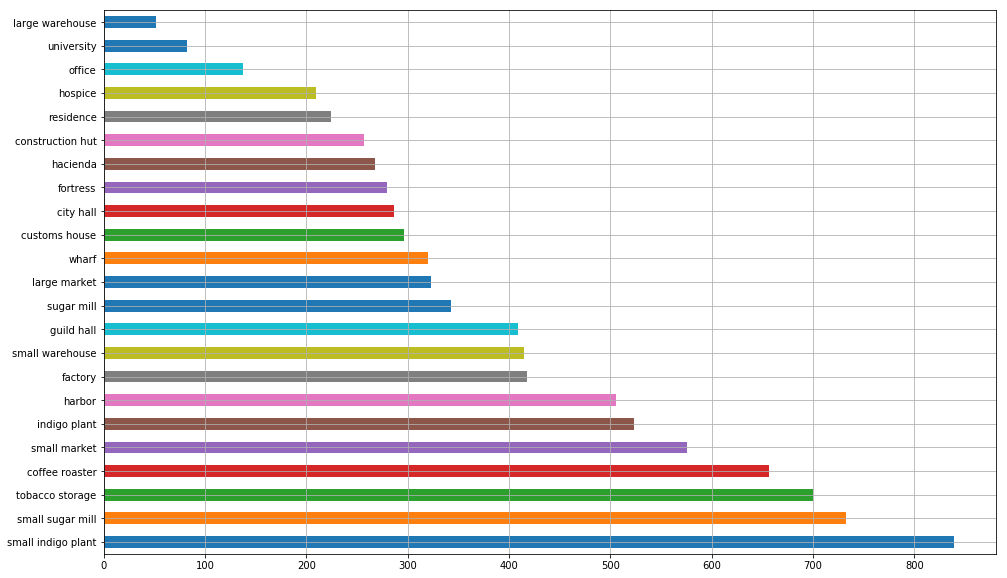

time: 839 ms


In [21]:
data = [{'table_id':b['table_id'], **collections.Counter(b['buildings'][b['rank']['1']])} for b in buildings]
s = pd.DataFrame(data).set_index('table_id').sum(axis=0)
ax = s.sort_values(ascending=False).plot.barh()
ax.grid(True)
plt.show()

---
# Average Score on Table
---

In [ ]:
def countGovernors(log):
    return 1+sum([1 for s in steps(log['data']) if s['type'] == 'newGovernor'])

In [ ]:
g = cached_to_disk(lambda: [countGovernors(l) for l in logs()], 'governors.json')

In [ ]:
s = [float(s['table']['stats']['2']) for s in stats_cache]

Trend (red): x = -21.8 +4.35•y


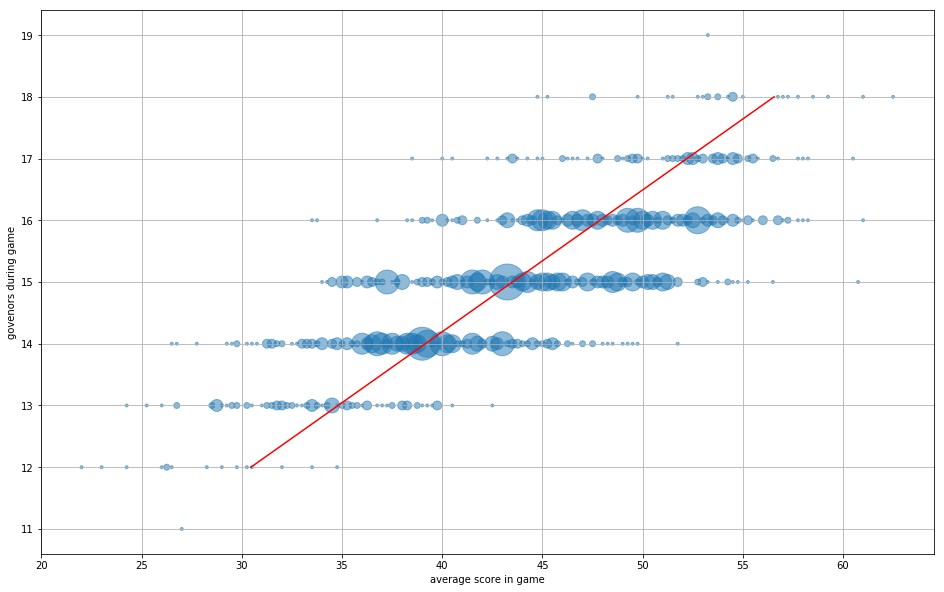

time: 759 ms


In [69]:
c = collections.Counter(zip(s, g))
sta_, gov_, sz = zip(*[(k[0], k[1], (3*v)**2) for k,v in c.items()])
sta_, gov_ = np.array(sta_), np.array(gov_)

#draw scores
fig, ax = plt.subplots()
ax.scatter(sta_, gov_, s=sz, alpha=.5)
ax.grid(True)
ax.set_xlabel('average score in game')
ax.set_ylabel('govenors during game')

# draw trend
trend = poly.polyfit(np.array(g), np.array(s), 1)
print('Trend (red): x = {:.3} {:+.3}\u2022y'.format(*trend))
ly = np.array([12, 18])
lx = poly.polyval(ly, trend)
ax.plot(lx, ly, 'r')

plt.show()

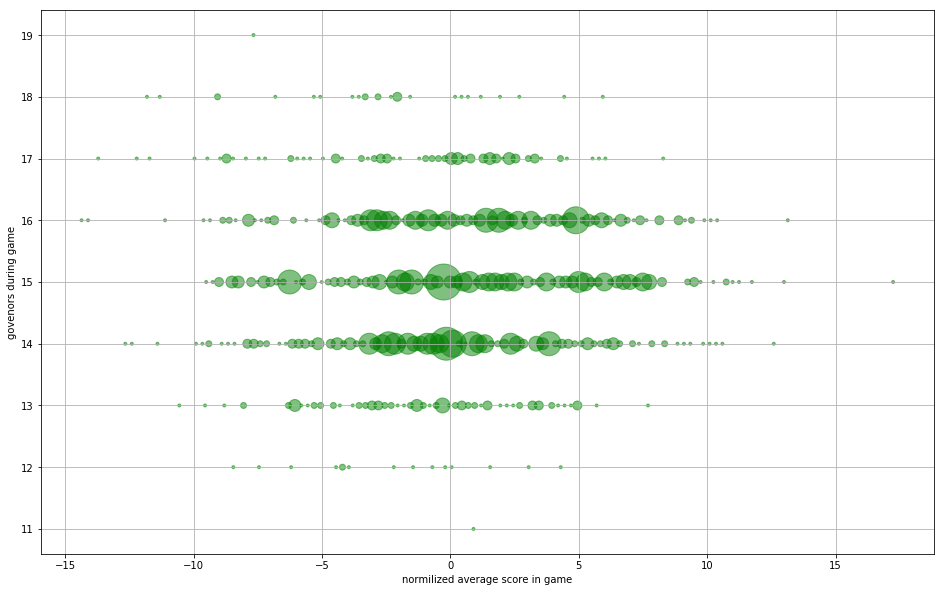

time: 785 ms


In [27]:
sta_2 = sta_ - gov_*trend[0] - trend[1]

fig, ax = plt.subplots()
ax.scatter(sta_2, gov_, s=sz, c='g', alpha=.5)
ax.grid(True)
ax.set_xlabel('normilized average score in game')
ax.set_ylabel('govenors during game')

plt.show()

Average Score on the table


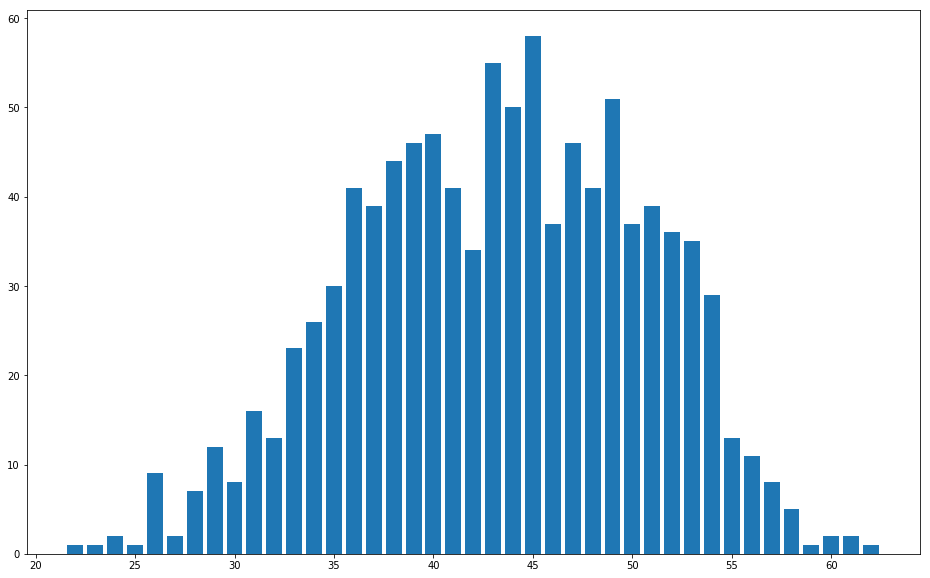

time: 683 ms


In [28]:
# avg = [int(p['table']['stats']['2']) for p in stats]
avg = [int(p) for p in s]
count = collections.Counter(avg)
plt.bar([x for x in count.keys()], [x for x in count.values()])
print('Average Score on the table')
plt.show()

Normalized Score on the table


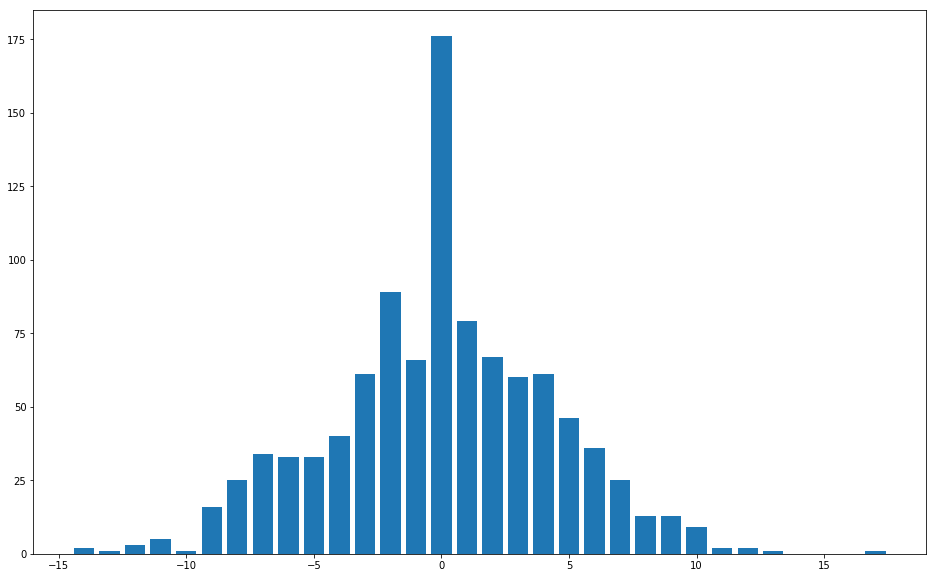

time: 673 ms


In [29]:
avg = [int(p - g[i]*trend[0] - trend[1]) for i,p in enumerate(s)]

count = collections.Counter(avg)
plt.bar([x for x in count.keys()], [x for x in count.values()])
print('Normalized Score on the table')
plt.show()

--- 
# Player Score
---

In [ ]:
dd = [(
    int(p['rank']),
    int(p['stats']['10']),
    int(p['stats']['11']),     
#     int(p['stats']['12'])    
) for game in stats_cache for p in game['result'] if int(p['rank']) == 1]

t = list(zip(*dd))

Trend (blue): x = +22.7 -0.0462•y -0.00224•y²


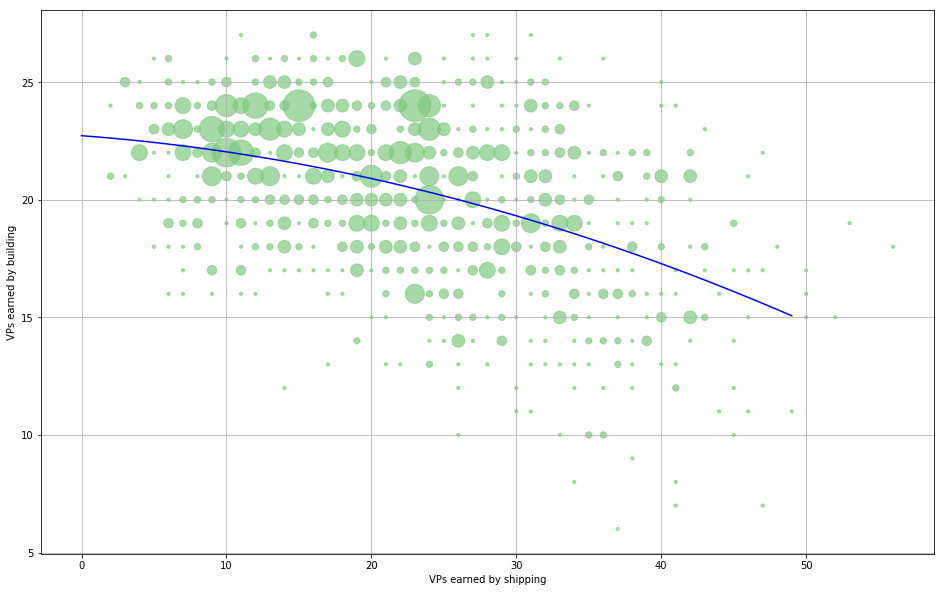

time: 689 ms


In [70]:
d = list(zip(*[(*k, v*v*10) for k,v in collections.Counter(dd).items()]))
fig, ax = plt.subplots()
ax.scatter(d[1], d[2], c=d[0],  s=d[3], alpha=0.7, cmap=plt.get_cmap('Accent'))
ax.grid(True)
ax.set_xlabel(player_stats['10'])
ax.set_ylabel(player_stats['11'])

trend = poly.polyfit(np.array(t[1]), np.array(t[2]), 2)
print('Trend (blue): x = {:+.3} {:+.3}\u2022y {:+.3}\u2022y\u00b2'.format(*trend))
lx = np.array(range(50))
ly = poly.polyval(lx, trend)
ax.plot(lx, ly, 'b')

plt.show()

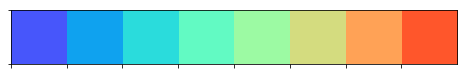

time: 267 ms


In [57]:
import seaborn as sns
sns.palplot(sns.color_palette("rainbow", 8))

In [49]:
dd = [(
    int(p['stats']['10']),
    int(p['stats']['11']),     
    g[i]-11
) for i,game in enumerate(stats_cache) for p in game['result'] if int(p['rank']) == 1]

t = list(zip(*dd))

time: 188 ms


Trend (blue): x = +22.7 -0.0462•y -0.00224•y²


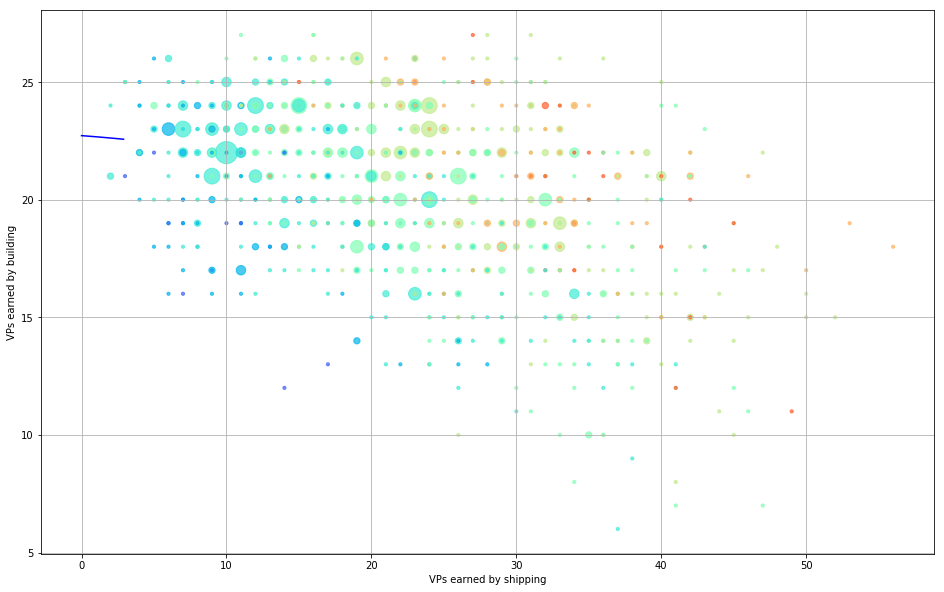

time: 784 ms


In [56]:
d = list(zip(*[(v*v*10, *k) for k,v in collections.Counter(dd).items()]))
fig, ax = plt.subplots()
ax.scatter(d[1], d[2], c=d[3], s=d[0], alpha=0.7, cmap=plt.get_cmap('rainbow'))
ax.grid(True)
ax.set_xlabel(player_stats['10'])
ax.set_ylabel(player_stats['11'])

trend = poly.polyfit(np.array(t[0]), np.array(t[1]), 2)
print('Trend (blue): x = {:+.3} {:+.3}\u2022y {:+.3}\u2022y\u00b2'.format(*trend))
lx = np.array(range(30))/10
ly = poly.polyval(lx, trend)
ax.plot(lx, ly, 'b')

plt.show()

In [ ]:
dd = [(
#     int(p['rank']),
    int(p['stats']['10']),
    int(p['stats']['11']),     
    int(p['stats']['12'])    
) for game in stats_cache for p in game['result'] if int(p['rank']) == 1]

t = list(zip(*dd))

In [19]:
import scipy
from scipy import stats

display(HTML('<h3>pearsonr</h3>'))
print('{:6.2f} : "{a}" & "{b}"'.format(*scipy.stats.pearsonr(t[0], t[1]), a=player_stats['10'], b=player_stats['11']))
print('{:6.2f} : "{a}" & "{b}"'.format(*scipy.stats.pearsonr(t[0], t[2]), a=player_stats['10'], b=player_stats['12']))
print('{:6.2f} : "{a}" & "{b}"'.format(*scipy.stats.pearsonr(t[1], t[2]), a=player_stats['11'], b=player_stats['12']))

 -0.45 : "VPs earned by shipping" & "VPs earned by building"
 -0.47 : "VPs earned by shipping" & "VPs earned from large buildings"
  0.58 : "VPs earned by building" & "VPs earned from large buildings"
time: 25.6 ms


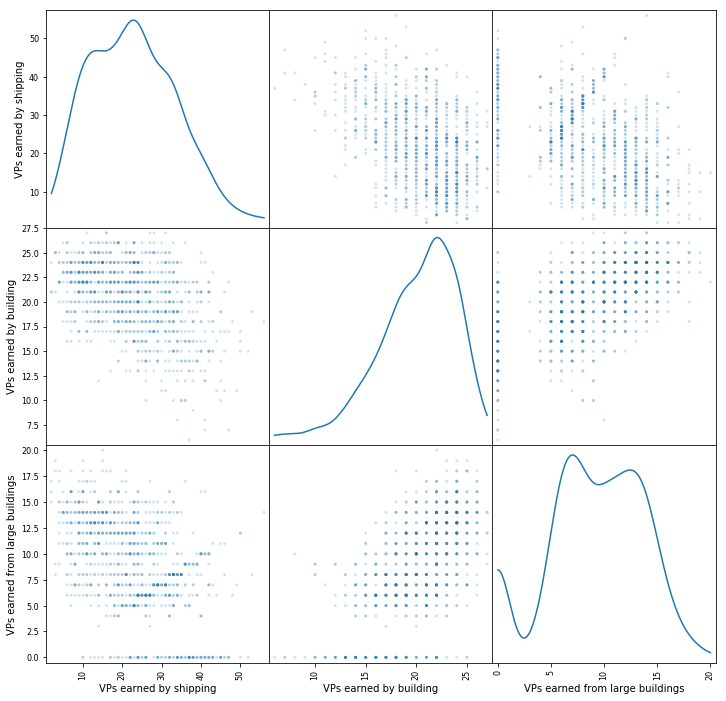

time: 2.72 s


In [27]:
from pandas.plotting import scatter_matrix

df = pd.DataFrame(dd, columns=[player_stats['10'], player_stats['11'], player_stats['12']])
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

---
## PICKED ROLES (TBD)

In [ ]:
def countRoles(log):
    lst = [(s['args']['player_name'], s['args']['rol_type']) for s in steps(log) if s['type'] == 'roleSelected']
    result = [{'name': k[0], 'role':k[1], 'count':c} for k,c in collections.Counter(lst).items()]
    return result

In [ ]:
pd.DataFrame([countRoles(l) for l in logs]).head(4)

## STATS EXAMPLE

In [30]:
tdf = pd.DataFrame([table_stats, stat['table']['stats']]).T
pdf = pd.DataFrame(
    data  = [player_stats] + [x['stats']  for x in stat['result']], 
    index =       ['name'] + [x['player'] for x in stat['result']]
).T

display_side_by_side(pdf, tdf)

,name,84921451,84851097,84921063,6317369
1,Thinking time,11.75,16.8333,13.5167,20.7
10,VPs earned by shipping,40,17,17,16
11,VPs earned by building,16,21,21,19
12,VPs earned from large buildings,10,16,7,0
13,Doubloons owned at game end,2,0,0,12
14,Good barrels owned at game end,0,0,0,0
15,Colonists,14,18,21,18
16,Plantations,8,4,10,7
17,Quarries,0,4,2,1
18,Small buildings,6,6,9,10


time: 19.4 ms


In [62]:
df_table = json_normalize(data=stats_cache).drop(columns=['result', 'file_name']).set_index('table_id')
df_table.head(5)

,table.concede,table.disagreement,table.neutralized,table.stats.1,table.stats.10,table.stats.11,table.stats.12,table.stats.13,table.stats.14,table.stats.15,table.stats.16,table.stats.2,table.stats.3,table.stats.4
table_id,,,,,,,,,,,,,,
40565834,False,False,0,4,21,11,59,13,0,19,0,43.25,62,177
41422564,False,False,0,4,66,5,60,14,2,20,0,30.75,44,149
41461557,False,False,0,4,23,5,73,12,0,16,0,44.75,52,182
41463045,False,False,0,4,23,1,73,20,2,12,0,49.00,55,181
41502058,False,False,0,4,4,1,56,18,0,16,0,50.75,57,192


time: 340 ms


In [61]:
df_player = json_normalize(data=stats_cache, record_path=['result'], meta='table_id')
df_player = pd.concat([df_player.drop(columns=['stats', 'color', 'color_back']), pd.DataFrame(df_player['stats'].tolist())], axis=1).set_index(['table_id', 'player'])
df_player.head(12)

concede            name  rank score score_aux    tie  \
table_id player                                                           
40565834 84685094        0           nmego     1    62         6  False   
         83971908        0             Pya     2    40         7  False   
         23240036        0        Ringking     3    37         7  False   
         84011443        0  cloudedcrystal     4    34        11  False   
41422564 4584848         0         kandale     1    44         7  False   
         84840595        0           Slift     2    43         4  False   
         84841138        0     sow00mill00     3    18        12  False   
         84765593        0             Eic     4    18         6  False   
41461557 1069424         0        ctcheung     1    52         2  False   
         84222461        0         Imanhol     2    48         0  False   
         84485493        0       suburbius     3    42         6  False   
         84755943        0          Fimera     4    37         2  False   

                   zombie        1  10  11  12  13 14  15  16 17 18 19  
table_id player                                                         
40565834 84685094       0    31343  23  22  17   6  0  15  10  2  5  3  
         83971908       0  56181.3  26  14   0   6  1  15   9  2  8  0  
         23240036       0  17027.6  14  17   6   6  1  18  10  1  6  1  
         84011443       0  67427.4  16  14   4   9  2  20   8  3  6  1  
41422564 4584848        0  31061.8  15  20   9   6  1  16   8  2  6  2  
         84840595       0  18384.7   6  21  16   3  1  20   9  1  5  3  
         84841138       0  32993.6   8  10   0  10  2  21   8  2  6  0  
         84765593       0  22730.4   5  13   0   6  0  17  11  1  7  0  
41461557 1069424        0  33060.2  21  20  11   2  0  18  12  0  8  2  
         84222461       0  22635.3  10  24  14   0  0  18   8  3  6  3  
         84485493       0  33014.3  24  18   0   6  0  20   9  3  8  0  
         84755943       0  16496.2  22  15   0   2  0  18   9  2  6  0

time: 196 ms


In [ ]:
pprint(stat, width=width)

### Other

In [ ]:
group = ['scoreShippingPoints', 'scoreConditionalPoints', 'scoreEndPoints', 'buildingBought']
selected = [s for s in steps(game_log) if s['type'] in group]
argsByType = lambda t: [s['args'] for s in selected if s['type'] == t]

buildings = {s['bld_id']: {
    'player_id': s['player_id'], 
    'building': s['bld_type_tr'],
    'score': int(s['score_delta'])
} for s in argsByType('buildingBought')}

buildings_score = {}
for b in buildings.values():
    buildings_score.setdefault(b['player_id'], 0)
    buildings_score[b['player_id']] += b['score']

JSON({
    'shipping'   : {s['player_id']: int(s['score_delta']) for s in argsByType('scoreShippingPoints')},
    'conditional': {s['building_name']: {
        s['player_id']: int(s['score_delta'])
    } for s in argsByType('scoreConditionalPoints')},
    'endScore'   : {s['player_id']: int(s['score_delta']) for s in argsByType('scoreEndPoints')},
    'buildings_s': buildings_score,
    'buildings'  : buildings
}, width=width)